# COGS 108 - EDA Checkpoint

# Names

- Leica Shen
- Yuxuan Wu
- Eddie Ho
- Xuewen Yang

<a id='research_question'></a>
# Research Question

How has the COVID-19 pandemic impact global warming? Specifically, how do changes in greenhouse gas emissions from 2020 to 2022 resulting from pandemic-related lockdowns impact the rate of global temperature increase and sea level rise?

# Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

In [ ]:
temp_change = pd.read_csv('data/global_land_and_ocean_temp_anomalies.csv', skiprows=4)
temp_change.head()

In [ ]:
temp_change.shape

In [ ]:
sea_level = pd.read_csv('data/Change_in_Mean_Sea_Levels.csv').drop(columns='ObjectId')
sea_level.head()

In [ ]:
sea_level.shape

In [ ]:
CO2_Concentrations = pd.read_csv('data/Atmospheric_CO2_Concentrations.csv').drop(columns='ObjectId')
CO2_Concentrations.head()

In [ ]:
CO2_Concentrations.shape

# Data Cleaning

Describe your data cleaning steps here.

### sea_level table

1. Extract `Year` and `Month` of each observation from the `Date` column and convert them into `int` data type. \
    The `Year` and `Month` columns from the above step will be combined with only the `Measure` and `Value` columns from the `sea_level` table. \
    The resulting merged data will be stored in the `sea_level_cleaned` table.
    

In [ ]:
sea_level_cleaned = pd.merge(sea_level[['Measure', 'Value']], sea_level['Date'].str.split('D', expand=True)[1].str.split('/', expand=True)[[0,2]].rename(columns={0:'Month', 2:'Year'}), left_index=True, right_index=True)
sea_level_cleaned['Year'] = sea_level_cleaned['Year'].astype(int)
sea_level_cleaned['Month'] = sea_level_cleaned['Month'].astype(int)
sea_level_cleaned.head()

2. Group by `Year` and `Month`, get the mean of `Value` of the `sea_level_cleaned` table. \
    The resulting table will be stored in the `mean_sea_level_by_month` table. \
    

In [ ]:
mean_sea_level_by_month = sea_level_cleaned.groupby(['Year', 'Month'])[['Value']].mean().reset_index().sort_values(['Year', 'Month']) 
mean_sea_level_by_month.head()

3. Group by `Measure` and `Year`, get the mean value of `Value` of the `sea_level_cleaned` table. \
    The resulting table will be stored in the `mean_sea_level_by_sea` table.

In [ ]:
mean_sea_level_by_sea = sea_level_cleaned.groupby(['Measure', 'Year'])[['Value']].mean().reset_index().sort_values(['Measure', 'Year']) 
mean_sea_level_by_sea.head()

### temp_change table

1. Create `temp_change_cleaned` data frame to store the cleaned data. 
2. Extract `Year` column from the original `temp_change` data frame, convert those dates to strings. 
3. Use string slicing to retrieve `Year` and `Month` from the dates in the uncleaned data frame, converts them to int, and then assign them to the corresponding `Year` and `Month` column of the cleaned `temp_change_cleaned` data frame. 
4. Sort the cleaned data in `temp_change_cleaned` by the `Year` and `Month` of the data. 

In [ ]:
temp_change_cleaned = temp_change.copy()
time = temp_change['Year'].astype(str)
temp_change_cleaned['Year'] = time.str[:4].astype(int)
temp_change_cleaned['Month'] = time.str[4:].astype(int)
temp_change_cleaned = temp_change_cleaned.groupby(['Year', 'Month']).mean().reset_index().sort_values(['Year', 'Month']) 
temp_change_cleaned.head()

### CO2_Concentrations table

1. Create `CO2_cleaned` dataframe to store the cleaned data.
2. Extract `Date` column from the original `CO2_cleaned` dataframe, use string slicing to retrieve `Year` and `Month`, and then assign them to the corresponding `Year` and `Month` column of the cleaned `CO2_cleaned` dataframe.
3. Drop rows where `Unit` = `Percent` as we won't be performing on those records.
4. Sort the cleaned data in `CO2_cleaned` by `Year` and `Month` of the data.

In [ ]:
# Extract the year and month from the date column
CO2_cleaned = (
    CO2_Concentrations
    .assign(Year=CO2_Concentrations['Date'].str.split('M').map(lambda x: x[0]).astype(int),
            Month=CO2_Concentrations['Date'].str.split('M').map(lambda x: x[1]).astype(int))
    .drop(columns=['Date'])
)

# Remove the percent values
CO2_cleaned = CO2_cleaned[CO2_cleaned['Unit'] != 'Percent']

# Sort the values by year and month
CO2_cleaned = (
    CO2_cleaned
    .sort_values(['Year', 'Month'])
    .get(['Year', 'Month', 'Value'])
)

CO2_cleaned

### Merging data sets

Our plan for combining these datasets: 
1. Merge the first dataset Temp Anomalies with the second dataset Change in Mean Sea Levels on the Year / Month columns.

2. Merge this combined dataset with the third dataset Atmospheric CO2 Concentrations again on the Year / Month columns.

In [ ]:
# Merge the two dataframes
mean_sea_level_by_month = mean_sea_level_by_month.rename(columns={'Value': 'Sea_Level'})
temp_change_cleaned = temp_change_cleaned.rename(columns={'Value': 'Temp_Anomaly'})
temp_sealevel_df = pd.merge(mean_sea_level_by_month, temp_change_cleaned, how='inner', on=['Year', 'Month'])
temp_sealevel_df.head()

The resulting merged data frame will have columns of `Year`, `Month`, `sea-level_value`, `temp_value`, `CO2_value`：

In [ ]:
CO2_cleaned = CO2_cleaned.rename(columns={'Value': 'CO2_Concentration'})
merged_df = pd.merge(temp_sealevel_df, CO2_cleaned, how='inner', on=['Year', 'Month'])
merged_df['Year_Month'] = pd.to_datetime(merged_df['Year'].astype(str)+ '-' + merged_df['Month'].astype(str))
merged_df.head()

# Data Analysis & Results (EDA)

### CO2_Concentration

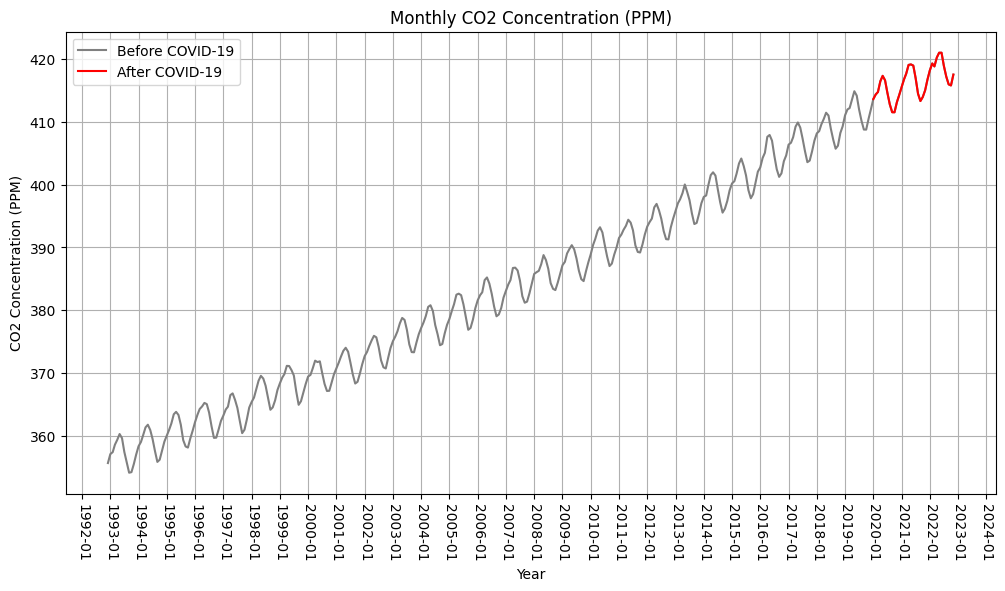

In [29]:
# Create a boolean mask for dates after 2019-12-01
mask = merged_df['Year_Month'] > pd.to_datetime('2019-12-01')

plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year_Month'], merged_df['CO2_Concentration'], label='Before COVID-19', color='gray')

# Use boolean mask to highlight data after Covid-19 outbreak
plt.plot(merged_df['Year_Month'][mask], merged_df['CO2_Concentration'][mask], label='After COVID-19', color='red')

plt.title('Monthly CO2 Concentration (PPM)')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (PPM)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.grid(True)
plt.xticks(rotation=-90)

plt.show()

This line graph illustrates the monthly $CO_2$ concentration in parts per million (ppm) over time on monthly basis. 

Notably, the graph reveals a distinct pattern characterized by a periodic Z-shape staircase trend.

At the beginning of each year, there is a noticeable increase in $CO_2$ concentration, represented by an upward trend in the graph. This upward trend is followed by a downward trend in the middle of the year and after that there is another upward trend towards the end of the year.

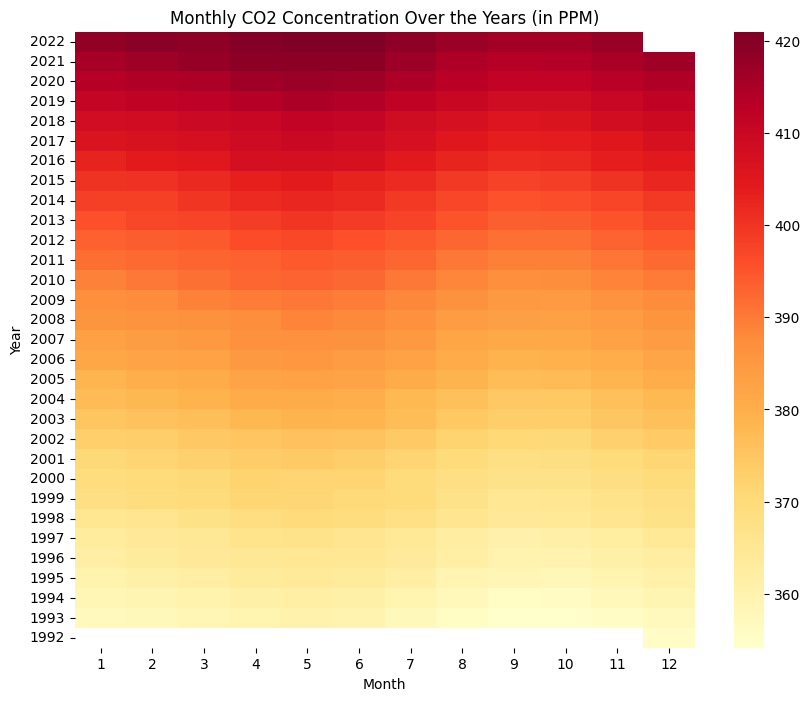

In [30]:
# Create a new DataFrame with years as index, months as columns, and CO2 concentration as values
heatmap_data = merged_df.pivot(index='Year', columns='Month', values='CO2_Concentration')
heatmap_data = heatmap_data.sort_index(axis=0, ascending=False)

# Draw the heatmap for monthly CO2 concentration
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd')

plt.title('Monthly CO2 Concentration Over the Years (in PPM)')
plt.xlabel('Month')
plt.ylabel('Year')

plt.show()

The heatmap illustrates the $CO_2$ concentration in parts per million (ppm) for each month of the years from 1992 to the present. The x-axis represents the months, while the y-axis shows the years in descending order, so the top of the graph represents the most recent data, while the bottom represents the earlier years. Also note that the color intensity signifies the $CO_2$ concentration. Darker shades indicate higher CO2 concentration and lighter ones represent lower concentrations.

The heatmap reveals a persistent trend of increasing $CO_2$ concentration over the years. Notably, the color intensity progressively darkens towards the top of the graph, which signifies a rising trend in $CO_2$ concentration. We observe that despite the global pandemic and consequent reduction in human activities, the $CO_2$ concentration does not show any sign of decrease. This observation is consistent with the findings of the graphs above, all of them are showing a steady increase in $CO_2$ concentration over the years. 

Here are two possible explanations for this observation:
1. Momentum of $CO_2$ emissions: The COVID-19 pandemic led to a reduction in human activities and consequently, $CO_2$ emissions. However, this reduction didn't mean an absolute halt. 
2. Persistence of $CO_2$ in the atmosphere: $CO_2$ persists in the atmosphere for a long time once it's released. Even with a significant short-term reduction in emissions, the concentration of $CO_2$ doesn't decrease quickly. 

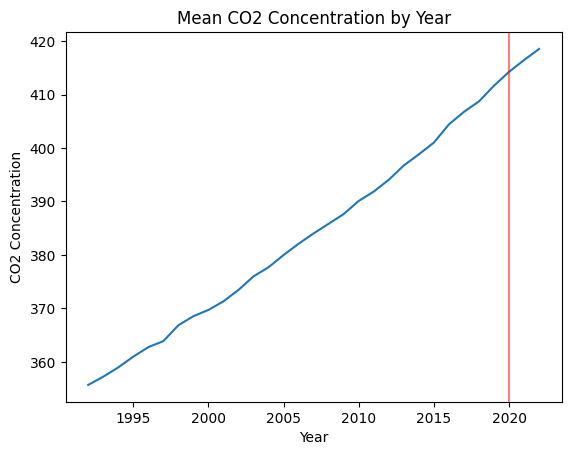

In [31]:
merged_df.groupby('Year')['CO2_Concentration'].mean().plot()
plt.xlabel('Year')
plt.ylabel('CO2 Concentration')
plt.title('Mean CO2 Concentration by Year')
plt.axvline(x=2020, color='red', alpha=0.5)
plt.show()

The line plot shows that $CO_2$ emissions have been increasing over the years. This indicates that despite the pandemic (2019-2022), there hasn't been a significant decrease in $CO_2$ emissions. This observation contradicts our initial anticipation of a decrease in emissions during the pandemic period.

Thus, instead of analyzing the impact of the **decrease** of $CO_2$ concentration to the rate of global temperature increase and sea level rise, we will analyze the impact of **overall** $CO_2$ concentration to the rate of global temperature increase and sea level rise. 

Starting by checking their correlations.

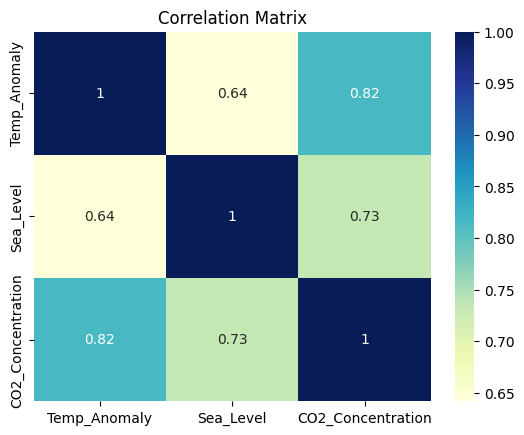

In [32]:
# Correlation analysis
correlation_matrix = merged_df[['Temp_Anomaly', 'Sea_Level', 'CO2_Concentration']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

The correlation matrix reveals that there is a strong positive correlation between $CO_2$ concentration and temperature anomalies, with a correlation coefficient of 0.82. This indicates a significant and positive relationship between the two variables. Similarly, there is a relatively strong positive correlation of 0.73 between $CO_2$ concentration and the average change in sea level.

However, it's crucial to note that correlation alone does not imply causation. While the high correlation coefficients suggest a relationship between the variables, further analysis is required to establish any causal connections or identify underlying factors. Thus, we are going to do more analysis below. 

### Temp_Anomaly

In [ ]:
# Temperature Anomly per Year
# Create a boolean mask for dates after 2019-12-01
mask = merged_df['Year_Month'] > pd.to_datetime('2019-12-01')

plt.figure(figsize=(12, 6))

# Plot all data with a lighter color
plt.plot(merged_df['Year_Month'], merged_df['Temp_Anomaly'], label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(merged_df['Year_Month'][mask], merged_df['Temp_Anomaly'][mask], label='After COVID-19', color='red')

plt.title('Monthly Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

df = merged_df[merged_df['Month'] == 1]

mask = (df['Year_Month'] > pd.to_datetime('2019-12-01')) & (df['Year_Month'] < pd.to_datetime('2022-12-01'))

# Plot all data with a lighter color
plt.plot(df['Year_Month'], df['Temp_Anomaly'], label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(df['Year_Month'][mask], df['Temp_Anomaly'][mask], label='After COVID-19', color='red')

plt.title('Temperature Anomalies on January')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

df = merged_df[merged_df['Month'] == 7]

mask = (df['Year_Month'] > pd.to_datetime('2019-12-01')) & (df['Year_Month'] < pd.to_datetime('2022-12-01'))

# Plot all data with a lighter color
plt.plot(df['Year_Month'], df['Temp_Anomaly'], label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(df['Year_Month'][mask], df['Temp_Anomaly'][mask], label='After COVID-19', color='red')

plt.title('Temperature Anomalies on July')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

In [ ]:
# Create a palette that maps each year to a color based on whether it's before or after 2020
palette = {year: 'orange' if year >= 2020 else 'yellow' for year in merged_df['Year'].unique()}

plt.figure(figsize=(12, 6))

# Create a boxplot with the custom color palette
sns.boxplot(x="Year", y="Temp_Anomaly", data=merged_df, palette=palette)

plt.title('Yearly Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')

plt.xticks(rotation=45)

plt.show()

### Sea_Level

In [ ]:
heatmap_data = merged_df.pivot_table(values='Sea_Level', index='Year', columns='Month').sort_index(ascending=False)
sns.heatmap(data=heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Sea Level (mm)'})
plt.title('Sea Level by Year and Month')
plt.show()

In [ ]:
sea_level_cleaned['Year_Month'] = pd.to_datetime(sea_level_cleaned['Year'].astype(str) + '-' + sea_level_cleaned['Month'].astype(str))
sea_level_world = sea_level_cleaned[sea_level_cleaned['Measure'] == 'World']
sea_level_cleaned.head()
sns.lineplot(x='Year_Month', y='Value', data=sea_level_world, errorbar=None)

In [ ]:
# Extracting the relevant columns
sea_level_data = sea_level_world[['Year', 'Value']]

# Perform linear regression
# Adding a constant term for the intercept
X = sm.add_constant(sea_level_data['Year'])
y = sea_level_data['Value']
model = sm.OLS(y, X)
results = model.fit()

# Extract slope and p-value
slope = results.params['Year']
p_value = results.pvalues['Year']

# Print regression results summary
print(results.summary())

In [ ]:
# Hypothesis testing
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. Sea level is rising.")
else:
    print("Fail to reject the null hypothesis. No significant evidence of sea level rise.")

In [ ]:
sea_level_by_year = (sea_level_cleaned
                     [sea_level_cleaned['Measure'] != 'World']
                     .groupby('Measure')
                     [['Value']]
                     .mean()
                     .reset_index())
mean_sea_level_world = (sea_level_cleaned
                        .loc[sea_level_cleaned['Measure'] == 'World', 'Value']
                        .mean(numeric_only=None))

sns.barplot(x='Value', y='Measure',
            data=sea_level_by_year.sort_values('Value', ascending=False))
plt.axvline(x=mean_sea_level_world, color='red', linestyle='--', label='World Mean')
plt.legend();